In [21]:
# the purpose of this notebook is to test the performance of our final attempt at an analytical solution:
# a case with plucking and sediment transport
# but no bedrock abrasion or grain attrition
# full derivation is below

Start with conservation of mass of sediment in a landscape "cell":
> $$\frac{\partial M}{\partial t} = \text{Mass in} - \text{Mass out}$$

The cell has height $H$, total width $B$, and length $dx$. Contained within the cell is a of channel width $b$. The sediment has porosity $\phi$ and density $\rho$. The cell is experiencing uniform uplift $U$. Mass is added via sediment flux into the cell, and generation of sediment within the cell via bedrock plucking. Plucking is a function of the fraction of bed cover, $\alpha$; sediment flux also depends on this quantity. Mass is lost via sediment flux out of the cell. Putting all these pieces together, we arrive at:
> $$\frac{\partial H B dx (1-\phi) \rho}{\partial t} = Q_s\bigr\rvert_{x} \rho + K\frac{Q}{B}S\alpha B dx \rho - Q_s\bigr\rvert_{x + \Delta x} \rho$$

We can remove the constants from the partial derivative and bring them to the RHS of the equation:
> $$\frac{\partial H}{\partial t} = \frac{Q_s\bigr\rvert_{x} \rho}{B dx (1-\phi) \rho} + \frac{K Q S \alpha B dx \rho}{B B dx (1-\phi) \rho} - \frac{Q_s\bigr\rvert_{x + \Delta x} \rho}{B dx (1-\phi) \rho}$$

Simplify, pull out the constant denominator:
> $$\frac{\partial H}{\partial t} = \frac{1}{(1-\phi)B} \left(\frac{Q_s\bigr\rvert_{x}}{dx} + K Q S \alpha - \frac{Q_s\bigr\rvert_{x + \Delta x}}{dx}\right)$$

Pull out -1, rearrange, and rewrite sediment flux pieces as a derivative:
> $$\frac{\partial H}{\partial t} = -\frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} - K Q S \alpha\right)$$

Set $dH/dt$ equal to 0, and go about solving for slope:
> $$0 = -\frac{1}{(1-\phi)B} \left(\frac{\partial Q_s}{\partial x} - K Q S \alpha\right)$$

> $$\frac{1}{(1 - \phi)B}\frac{\partial Q_s}{\partial x} = \frac{K Q S \alpha}{(1-\phi)B}$$

> $$\frac{\partial Q_s}{\partial x} = K Q S \alpha$$

At steady state, uplift = erosion, meaning uplift rate = plucking rate. We can write this as:

> $$U = K \frac{Q}{B} S \alpha$$

We can rearrange this to solve for $\alpha$:

> $$\alpha = \frac{UB}{KQS}$$

This can be plugged into the equation for sediment flux above, giving us:

> $$\frac{\partial Q_s}{\partial x} = UB$$

Now we continue working towards isolating slope, which lives in the equation for $Q_s$:

> $$d Q_s = UB  dx$$

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# define parameters

dx = 1000 # grid spacing
x = np.arange(0, 5000, dx) # domain length
x_node = x + dx/2

baselevel_rate = 0.001 # uplift rate
phi = 0.55 # sediment porosity
kqs = 0.041 # sediment discharge coefficient
I = 0.01 # intermittency factor
r = 10. # runoff rate
S0 = 0.15 # slope linearizer
K = 0.00001 # erodibility
# K[:3] = 0.000001
# K[3:] = 0.00001
Hstar = 0.5
kxb = 25 # valley width coeffecient (a, above)
Pxb = (1/5) # valley width exponent

In [5]:
# set up arrays

H = Hstar + np.zeros(len(x)) # sediment thickness
etab = np.zeros(len(x)) # bedrock elevation array
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
eta = etab + H # total topographic elevation

In [6]:
# calculate constant, derivative values

B = kxb * (x_node**Pxb) # valley width   ## TWEAKED
Q = (r * kxb * x**(6/5))/(1 + Pxb) # discharge  ## WE TWEAKED THIS

In [7]:
def model(x,
          dx,
          Hstar,
          H,
          etab,
          eta,
          kqs,
          I,
          K,
          kxb,
          Pxb,
          phi,
          baselevel_rate,
          Q,
          B,
          num_steps = 1000000):
    
    dx = 1000 # grid spacing
    x = np.arange(0, 5000, dx) # domain length
    x_node = x + dx/2
        
    # calculate timestep
    dt = 0.2 * (0.2 * dx * dx / (kqs*(Q[-1]/B[-1])))
    
    # define arrays
    Eb = np.zeros(len(x)) # bedrock erosion rate
    Eb_total = np.zeros(len(x)) # total bedrock erosion rate
    Eh = np.zeros(len(x)) # sedimentation rate
    E = np.zeros(len(x)) # total erosion rate
    Qs = np.zeros(len(x)) # total sediment transport
    
    # set boundary conditions
    #H[-1] = 0
    E[-1] = 0 # also try baselevel_rate
    Qs[0] = 0
    
    for i in range(num_steps):
            
        # calculate slope
        S = np.abs(np.diff(eta)/dx)
        
        # calculate bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calculate sediment transport (L^3/T)
        Qs[1:] = kqs * I * Q[1:] * (S** (7./6.)) * (1-alpha[:-1])
        
        # calculate bedrock erosion rate (plucking) (L^2/T)
        Eb[:-1] = K * Q[1:] * S * alpha[:-1]
        
        # total bedrock erosion (L/T)
        Eb_total = Eb / B
       
        # calculate sedimentation rate (L/T)
        Eh[:-1] = - (1/((1 - phi) * B[1:])) * ((np.diff(Qs)/dx) - Eb[:-1])
        
        # calculate total erosion rate (L/T)
        E[:-1] = Eb_total[:-1] + Eh[:-1]
        
        # update boundary conditions
        eta[-1] -= baselevel_rate * dt
        etab[-1] = eta[-1]
        
        # update topography
        etab[:-1] -= Eb_total[:-1] * dt
        H[:-1] += Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]

        
    return (S, alpha, Qs, Eb, Eb_total, Eh, E, eta, etab, H, dt)

In [8]:
# now write a test
test = [dx, x, Hstar, H, etab, eta, kqs, I, K, kxb, Pxb, phi, baselevel_rate, Q, B]

# and run it
S, alpha, Qs, Eb, Eb_total, Eh, E, eta, etab, H, dt = model(*test)

In [9]:
E

array([0.001, 0.001, 0.001, 0.001, 0.   ])

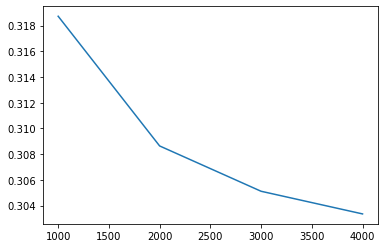

In [17]:
plt.plot(x[1:], S)

In [18]:
# now calc slopes analytically
slope_prediction = (6/5) * ((baselevel_rate/(kqs * I * S0 * r * kxb * x[1:]**(1/5))) + (baselevel_rate/(K * r * kxb * x[1:]**(6/5))))

In [19]:
slope_prediction

array([0.01972554, 0.0171196 , 0.01576998, 0.01488063])

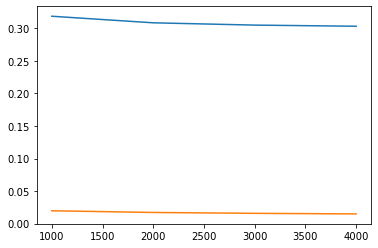

In [20]:
plt.plot(x[1:], S)
plt.plot(x[1:], slope_prediction)